# Unit4_Lesson2_Project5: Challenge: Boston marathon
Thinkful Data Science: https://courses.thinkful.com/data-201v1/project/4.2.5 <br>
Start: 12/02/2019

**Desciption:** Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [1]:
#general tools
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

#Modelling tools
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from sklearn.preprocessing import normalize

from sklearn import metrics
from sklearn.metrics import pairwise_distances


#Mescellanous tools
import missingno as msno

In [2]:
#Grabbing data and taking a glimse
PATH = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'
data = pd.read_csv(PATH)
data.head(5)

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
#variables in data
data.columns

Index(['10k', 'name', 'division', '25k', 'gender', 'age', 'official', 'bib',
       'genderdiv', 'ctz', '35k', 'overall', 'pace', 'state', '30k', '5k',
       'half', '20k', 'country', 'city', '40k'],
      dtype='object')

## Variable description:

Source: https://www.kaggle.com/rojour/boston-results
-  `10k, 25k, 35k, 5k, 20k, 40k` and `half`: time taken for a runner to complete distance milestones
-  `official`: runner's official fininshing time
-  `bib`: assigned race number based on qualifying time. "F" could appear for female elites, wheelchair athletes start with W
-  `division`: runner's ranking in their age division.
-  `genderdiv`: runner's ranking in their gender division.
-  `overall`: runner's overall raking.
-  `pace`: runner's overall minute per mile pace.
-  `state`: runner's state of residence (if applicable).
-  `city`: runner's city of residence.

## Exploring the data:

In [4]:
#first lets see the top 50 performing athletes and their metrics. 
data_top = data.sort_values(by=['overall'], axis=0, ascending=True)[['overall', 'official', 'bib', 'name']]

#I will not include wheelchair athletes

#df[df.SIC.str.isalpha()]
#data_top[pd.isnumeric()(data_top.bib, errors='coerce').isnull()]
#data_top[pd.to_numeric(data_top.bib, errors='coerce')]
#pd.to_numeric(data_top.bib, errors='coerce').dropna()

#data_top[data_top.bib.isin()]

**I will come back for further data exploration later**

## Data Cleaning - in preparation for Clustering

In [5]:
# which are the numerical variables?
data._get_numeric_data().head()

,division,age,official,genderdiv,overall,pace
0,8,47,85.25,8,8,3.27
1,1,33,138.95,1,21,5.30
2,1,41,80.60,1,1,3.08
3,3,24,140.58,3,27,5.37
4,2,40,81.23,2,2,3.10


In [6]:
#it seems that there some strange character in our data row, this is the reason some of the numerical
#columns are not comming up.
#A look at 5k column showed that '-' has been used to represent missing data. I will replace this with 'nan'
data.replace('-', np.nan, inplace=True)
data.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [7]:
#let's try again
data._get_numeric_data().head()

,division,age,official,genderdiv,overall,pace
0,8,47,85.25,8,8,3.27
1,1,33,138.95,1,21,5.30
2,1,41,80.60,1,1,3.08
3,3,24,140.58,3,27,5.37
4,2,40,81.23,2,2,3.10


**Still the same issue. A look at 5k showed the numerical values have been quoted as string. I will convert the strings to floats** <br>I could figure out how to apply a lambda function to multiple columns in pandas, so I had to write a fucrion to do it

In [8]:
#create a function to convert numerial strings to float
def to_float(df, col_list):
    df1 = df.copy()
    for col in col_list:
        df1[col] = df1[col].apply(lambda x: float(x)).copy()
    return df1

#apply function
data = to_float(data, ['10k','25k','35k','30k','5k','20k','half','40k']).copy()

In [9]:
#I will now check if the function worked by getting a decsription of the data, obviously string variables will be be described
data.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31934.000000,31984.000000,31768.000000,31984.000000,31984.000000,31984.000000,31950.000000,31984.000000,31984.000000,31944.000000,31932.000000,31912.000000,31933.000000,31945.000000
mean,51.799275,1932.563032,133.612055,42.407079,242.997314,8051.044741,196.857605,15939.587825,9.275658,164.571219,25.755559,111.664566,105.711669,229.001490
std,8.965513,1715.228694,25.596958,11.316496,52.300431,4754.005626,41.979107,9232.978224,1.992486,33.953683,4.327830,21.061188,19.780525,49.159902
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.470000,33.000000,205.527500,3972.000000,167.122500,7943.750000,7.850000,140.670000,22.650000,96.845000,91.750000,193.820000
50%,50.330000,1425.000000,128.875000,42.000000,232.370000,7970.000000,188.170000,15939.500000,8.870000,157.730000,25.080000,107.830000,102.150000,218.850000
75%,57.170000,2611.000000,147.735000,50.000000,273.235000,11968.000000,220.170000,23935.250000,10.430000,182.880000,28.470000,123.070000,116.520000,257.450000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


**Perfect! It worked, now is time to deal with nan.**

### Treating NANs
First I will visualize the nan to have an idea of their destribution. I will treat the string and numerical nans accordingly.

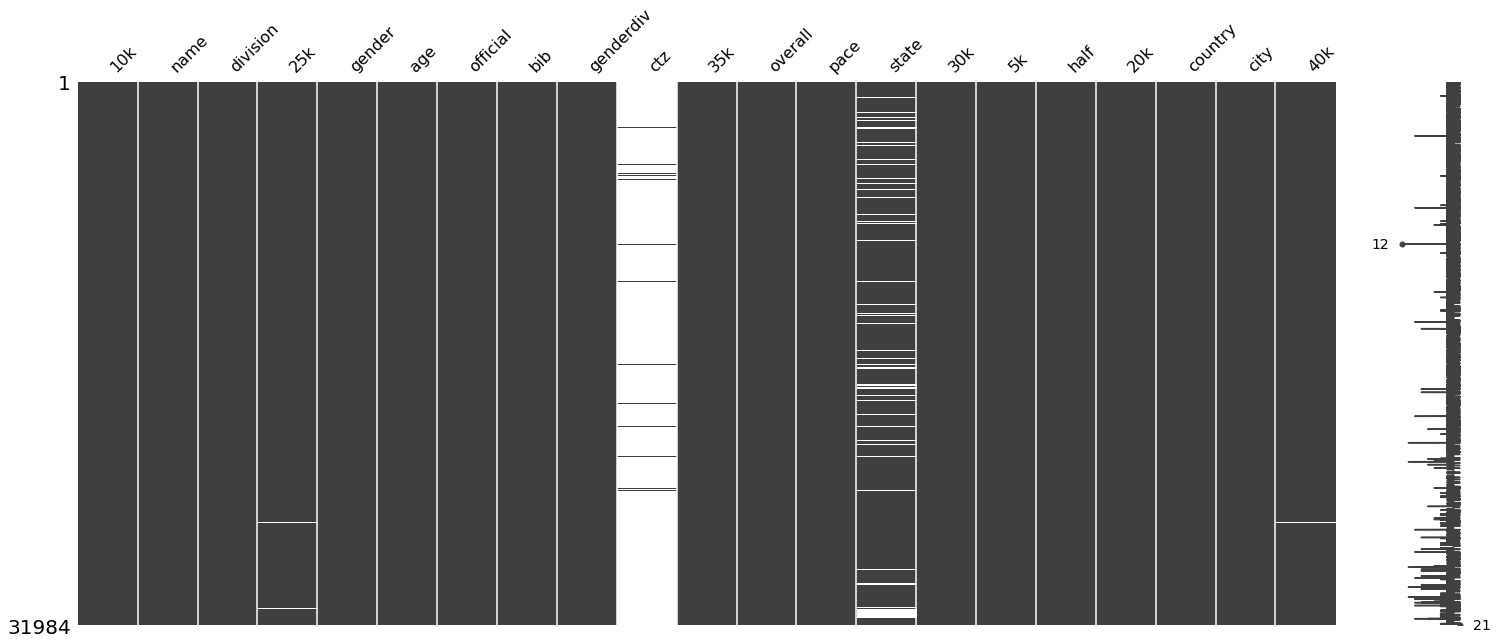

In [10]:
#visualize na
msno.matrix(data)

**First we can see that most of the rows in `ctz`, this column will thereby be dropped. The `state` variable also has a substantial number of missed values and will be dropped as well. Finally I will drop every other row with missing observation.**

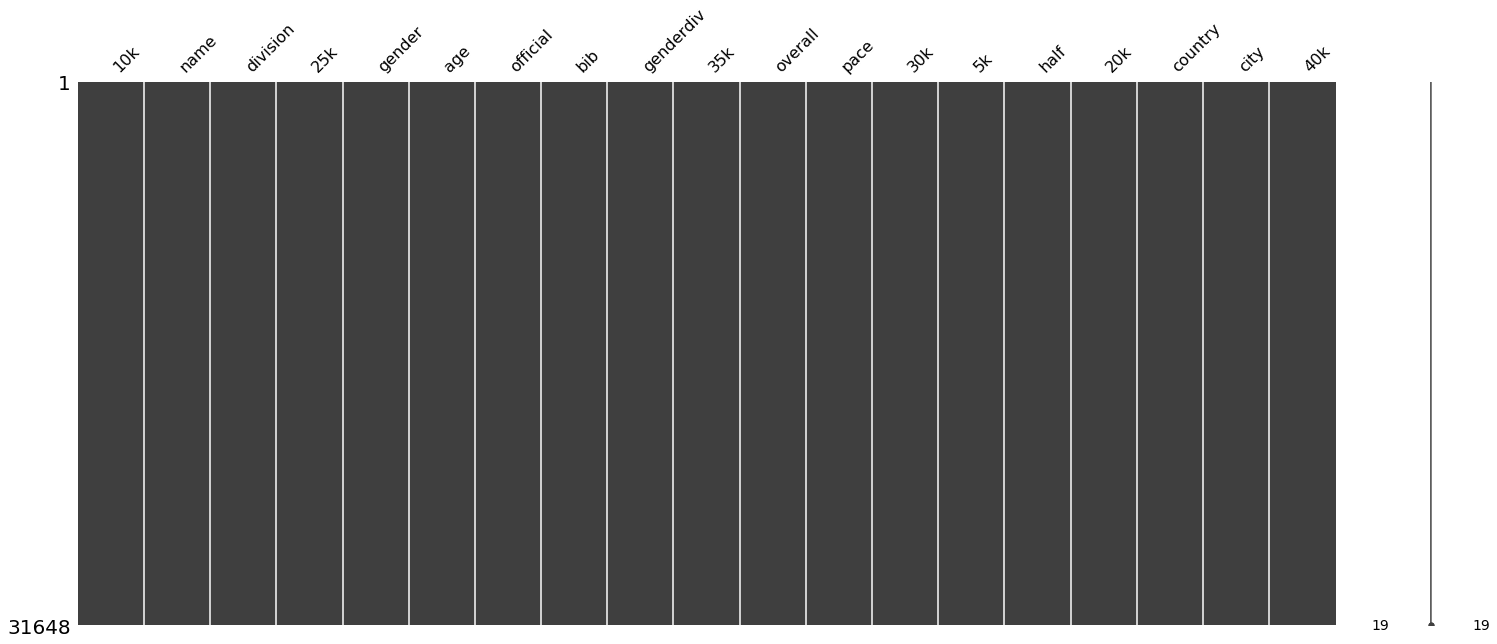

In [11]:
#drop ctz and state from data
data.drop(['ctz', 'state'], axis=1, inplace=True)

#drop na by rows
data.dropna(inplace=True)

#lets see what we got
msno.matrix(data)

### Dealing with categorical and other non numerical variables

**First let see the non-numerical variable in our data and explore them one after the other**

In [12]:
#extract non-numerical variable in our data
num_variables = (data._get_numeric_data()).copy().columns

#now let's get the non-numerial ones as well
non_num_variables = data.loc[:, ~data.columns.isin(num_variables)].columns

-  **`Gender`:**Will be factorized using `1-hot-encode`
-  **`bib` and `name`:**are unique to every athlete, they bears no statistical value and would thereby be `dropped`
-  **`country and city`:**are too large for factorization, they will be `dropped` as well.

In [13]:
#treating non-numerical variables
data_clean = data.drop(['bib', 'country', 'city', 'name'], axis=1).copy()

#factorize gender
data_clean = pd.get_dummies(data_clean).copy() 

#let's see what we got
data_clean.head()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_F,gender_M
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,0,1
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,1,0
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,0,1
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,1,0
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,0,1


In [14]:
#Finally let's see the distribution of our variables
data_clean.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_F,gender_M
count,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000,31648.000000
mean,51.629090,1922.800367,133.581381,42.384700,241.952878,8003.025404,196.033725,15834.008658,9.236483,163.895155,25.678275,111.211631,105.321547,228.190455,0.447548,0.552452
std,8.710235,1704.844465,25.571858,11.299784,50.843279,4733.295012,40.775632,9182.364552,1.939178,32.889838,4.215447,20.306691,19.159786,48.075181,0.497249,0.497249
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000,0.000000,0.000000
25%,45.370000,607.000000,115.430000,33.000000,205.300000,3940.000000,166.950000,7879.750000,7.830000,140.515000,22.620000,96.750000,91.670000,193.620000,0.000000,0.000000
50%,50.280000,1418.000000,128.850000,42.000000,231.980000,7919.000000,187.850000,15829.500000,8.850000,157.500000,25.050000,107.680000,102.000000,218.475000,0.000000,1.000000
75%,57.000000,2601.000000,147.700000,50.000000,272.200000,11893.000000,219.370000,23785.250000,10.380000,182.200000,28.400000,122.680000,116.150000,256.570000,1.000000,1.000000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000,1.000000,1.000000


**Finally, our data is ready for `clustering`, but first it would have to be `re-scaled`**

In [15]:
#Before scaling the data, the binary columns(M and F) would have to be converted to floats, 
#otherwise they will not be captured in the scalling

#convert to floats
data_clean['gender_F'] = data_clean.gender_F.astype("float64").copy()
data_clean['gender_M'] = data_clean.gender_M.astype("float64").copy()

sc = StandardScaler()
data_scaled = pd.DataFrame(sc.fit_transform(data_clean), columns=data_clean.columns)
data_scaled.head()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,gender_F,gender_M
0,-3.933261,-1.123170,-3.359660,0.408448,-3.082125,-1.689130,-3.056622,-1.723549,-3.076859,-3.183865,-4.189011,-3.520651,-3.532013,-3.073577,-0.900062,0.900062
1,-2.187012,-1.127276,-2.000331,-0.830533,-2.025922,-1.690609,-1.953740,-1.722134,-2.030007,-1.963104,-2.243754,-2.055593,-2.061201,-1.998785,1.111034,-1.111034
2,-4.019368,-1.127276,-3.432788,-0.122544,-3.173584,-1.690609,-3.154231,-1.724312,-3.174840,-3.266871,-4.253062,-3.603876,-3.612913,-3.163646,-0.900062,0.900062
3,-2.188160,-1.126103,-2.000331,-1.627021,-1.993862,-1.690187,-1.953740,-1.721480,-1.993909,-1.963104,-2.248498,-2.055593,-2.061201,-1.981105,1.111034,-1.111034
4,-3.961964,-1.126690,-3.410498,-0.211043,-3.161193,-1.690398,-3.144176,-1.724203,-3.164527,-3.249236,-4.189011,-3.575806,-3.587860,-3.150749,-0.900062,0.900062


# Data Clustering
As hightlighted in the `description` above. What I set out to do in this project is to run a number of clustering algorithms with various number of clusters on this data. In the end I will check which algorithm(s) is/best in terms of fold consistecy and approximate cluster visualization using PCA. PCA will be used to resolve the 16 dimensional data into 2 dimensions, each time a clustering algorithm is ran, the predicted cluster values will be used to color the plot of the data's two components plot. I will code up a function to perform these tasks for every pair of algorithm and number of clusters.

In [16]:
# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
data_pca = pd.DataFrame(pca.fit_transform(data_scaled))

#split the data into four equal folds
num_rows = data_scaled.shape[0]-data_scaled.shape[0]%4
data_scaled = data_scaled.loc[:num_rows, :].copy()

# Split the data into four equally-sized samples. First we break it in half:
data_half1, data_half2, data_pca_half1, data_pca_half2 = train_test_split(
    data_scaled,
    data_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    data_half1,
    data_pca_half1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    data_half2,
    data_pca_half2,
    test_size=0.5,
    random_state=42)

**Code up a function to run clustering algorithms and plot predicted classification against the corresponding PCA folds**

### KMeans Solution

In [17]:
#this function takes the data and pca folds and the list of n_clusters to be tested
def clusterize(alg_name, data_splits, pca_split, n_clusters):
    
    #for each number of clusters i.e n_clusters
    for clust in n_clusters:
        
        # Make a grid of subplots for each fold for this n_cluster
        grid_list = [[0,0], [0,1], [1,0], [1,1]]
        f, axarr = plt.subplots(2, 2)
        silhouette_scores = []
        for i in range(len(data_splits)):

            #fit and generate prediction for each data fold at this n_cluster
            pred = alg_name(n_clusters=clust, random_state=42).fit_predict(data_splits[i])
            
            #calculate the silhouette_score for this model
            model = alg_name(n_clusters=clust, random_state=42).fit(data_splits[i])
            labels = model.labels_
            silhouette_scores.append(metrics.silhouette_score(data_splits[i], labels, metric='euclidean'))

            #generate the clustering visualization by plotting the components of the 
            #pca as x and y and the predicted from X as c
            axarr[grid_list[i][0], grid_list[i][1]].scatter(pca_split[i][0], pca_split[i][1], c=pred)
        print('silhouette_scores: {}'.format(silhouette_scores))
              
        # Space out the plots so that the headings don't overlap axis values.
        plt.suptitle('{} Clusters'.format(clust), fontsize=15)
        plt.tight_layout()
        plt.show()
        print('\n')
        
    return pred

silhouette_scores: [0.4220093640738831, 0.4232086806254128, 0.4264791967300034, 0.41723524214173635]


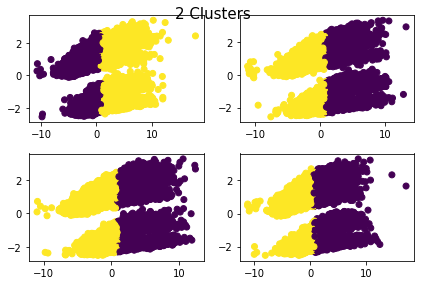



silhouette_scores: [0.3177479649278341, 0.317437318216898, 0.31659623747049603, 0.3160369339692091]


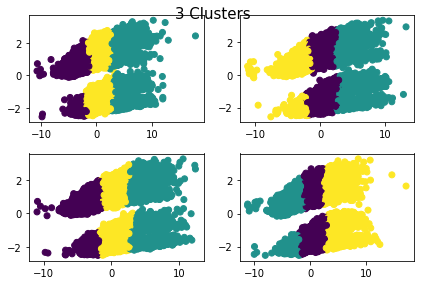



silhouette_scores: [0.3431430588107546, 0.3644311851528498, 0.33804017040125206, 0.35847541008764117]


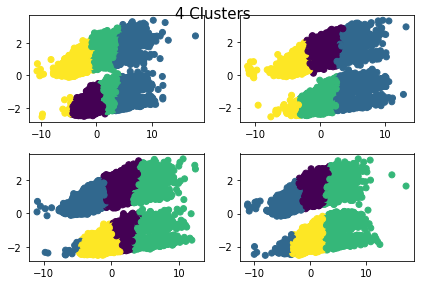



silhouette_scores: [0.3553914219263105, 0.33603366222240033, 0.3316965144747689, 0.3509719735580716]


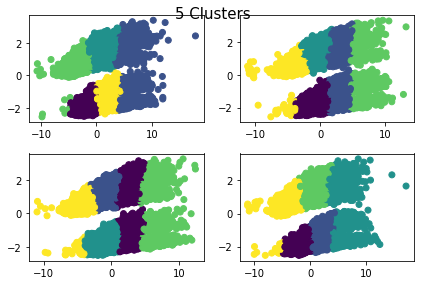

array([1, 1, 2, ..., 3, 4, 3])

In [18]:
#run KMeans using 2, 3, 4 and 5 clusters over the four folds and generate the pca plots each n_clusters
clusterize(KMeans, [X1,X2,X3,X4], [X_pca1,X_pca2,X_pca3,X_pca4], [2, 3, 4, 5])

**As we can see from the plot: the best solution as per `KMeans` interms of number of clusters and consistency throughout the splits is the 3 clusters solution. Sure, the 2 cluster solution is the most consistent accross all folds, but the 3 cluster solution is not only almost equally consistent but also allowed for an additional cluster.**

### MiniBatchKmeans Solution

silhouette_scores: [0.4182728065836897, 0.4255926045952068, 0.421341555882078, 0.4223821112014828]


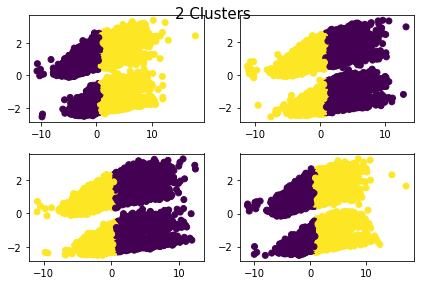



silhouette_scores: [0.34975522265836684, 0.3172904336940044, 0.31770266013981074, 0.34927300004828604]


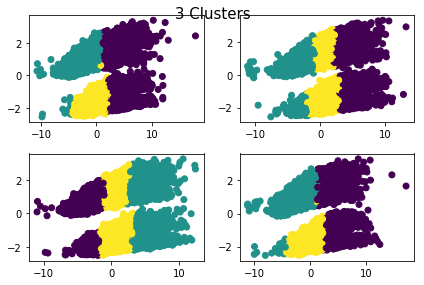



silhouette_scores: [0.34201473083078154, 0.3477498019649893, 0.3565179468767249, 0.3351230872130156]


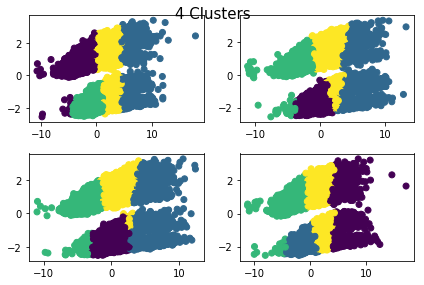



silhouette_scores: [0.3612550340136756, 0.3407015496304836, 0.3264330362430231, 0.3404057532234664]


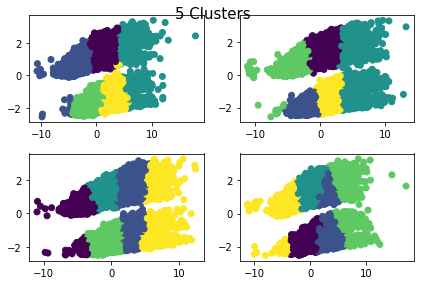

array([1, 1, 1, ..., 2, 4, 2])

In [19]:
#run KMeans using 2, 3, 4 and 5 clusters over the four folds and generate the pca plots each n_clusters
clusterize(MiniBatchKMeans, [X1,X2,X3,X4], [X_pca1,X_pca2,X_pca3,X_pca4], [2, 3, 4, 5])

**This result is very similar to what we had with `KMeans` above, we can make exaclty the same conclusion that the 3 cluster solution is the best for this data set owing to it consistency accross folds and it's number of clusters.**

### Silhouette
Since we do not have a `Ground Truth` in the data to compare our clustering solution with, we will used the `Silhouette` coefficient to do a further assesment(after the pca plots above).<br>
<br>
Silhouette is based on the assumption that a good cluster is made up of datapoints that are more similar to one another than they are to datapoints in other clusters. One way of computing similarity is the silhouette coefficient. 
<br>
I have now included the Silhouette score in the function and the output for each instance of KMeans and KMeansMiniBatch now includes a Silhouette score. 

### MeanShift Algorithm

In [20]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [21]:
#this function takes the data and pca folds and the list of n_clusters to be tested
def clusterize_1(alg_name, data_splits, pca_split):
        
    # Make a grid of subplots for each fold for this n_cluster
    grid_list = [[0,0], [0,1], [1,0], [1,1]]
    f, axarr = plt.subplots(2, 2)
    silhouette_scores = []
    for i in range(len(data_splits)):
            
        #declare the bandwidth for the mean- shift algorithm
        bandwidth = estimate_bandwidth(data_splits[i], quantile=0.2, n_samples=200)
            
        # Declare and fit the model.
        ms = alg_name(bandwidth=bandwidth, bin_seeding=True)
        ms.fit(data_splits[i])
            
        # Extract cluster assignments for each data point.
        labels = ms.labels_

        # Coordinates of the cluster centers.
        cluster_centers = ms.cluster_centers_

        # Count our clusters.
        n_clusters_ = len(np.unique(labels))

        print("Number of estimated clusters: {}".format(n_clusters_))

        #generate the clustering visualization by plotting the components of the 
        #pca as x and y and the predicted from X as c
        axarr[grid_list[i][0], grid_list[i][1]].scatter(pca_split[i][0], pca_split[i][1], c=labels)
              
        # Space out the plots so that the headings don't overlap axis values.
        plt.suptitle('{} Clusters'.format(n_clusters_), fontsize=15)
        plt.tight_layout()
        plt.show()
        print('\n') 

Number of estimated clusters: 3


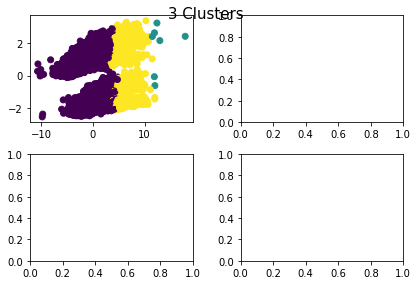



Number of estimated clusters: 1


<Figure size 432x288 with 0 Axes>



Number of estimated clusters: 1


<Figure size 432x288 with 0 Axes>



Number of estimated clusters: 2


<Figure size 432x288 with 0 Axes>

In [22]:
#run meanshift clustering on all data folds
clusterize_1(MeanShift, [X1,X2,X3,X4], [X_pca1,X_pca2,X_pca3,X_pca4])

*MeanShift seems not to be a good solution for this dataset. The results are not consistent ranging from 1 to 3 clusters among the data folds. Also I could not figure out why the pca/label plot is only showing for the first fold.*

# Grouping of Athletes
Now I will go back to the 3 cluster solution of the Kmeans above, but this time around I will run the model on the entire data at once and apend the generated labels back to the data just to see how athletes are grouped together. In order to suit this this purpose, I have modified the function to also return the `pred`. If the modified function is run with multiple folds and n_clusters, only the `pred` of the last batch would be returned. 

silhouette_scores: [0.3167033869881565]


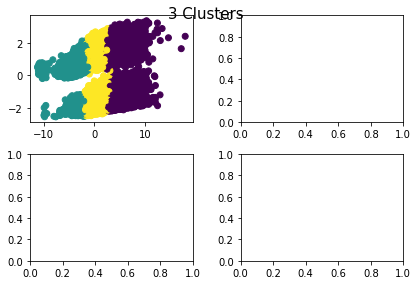

In [23]:
#run kMeans function with 3 clusters
clusters = clusterize(KMeans, [data_scaled], [data_pca], [3])

**Now that I have the the cluster labels `clusters`. I will then append it to the original dataset to see which athlete belong to which group**

In [26]:
data_clustered = data.copy()
data_clustered['cluster'] = clusters
data_clustered

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k,cluster
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,1
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,1
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1
5,32.58,"Sumgong, Jemima Jelagat",4,82.45,F,29,140.68,F3,4,116.37,28,5.37,99.33,16.22,69.47,65.83,KEN,Nandi,132.95,1
6,17.65,"Hug, Marcel E.",4,47.67,M,28,84.65,W4,4,70.23,4,3.23,58.60,8.38,39.72,37.65,SUI,Neuenkirch,79.83,1
7,30.48,"Geneti, Markos",5,76.95,M,29,129.83,5,5,107.47,5,4.97,92.52,15.17,64.85,61.62,ETH,Addis Ababa,122.80,1
8,17.12,"Soejima, Masazumi",3,46.37,M,43,81.23,W6,3,67.83,3,3.10,57.03,8.00,38.60,36.60,JPN,Isahaya,76.70,1
9,30.48,"Hall, Ryan",20,77.68,M,31,137.83,6,20,112.27,20,5.27,94.78,15.15,65.23,61.78,USA,Redding,129.83,1


**Now we know which athlete belong to which cluster, the next question is what do these individual athletes have in common that propelled our algorithm to cluster them together? To answer this question I will extract each group from the data and study them seperately.** 

### Cluster `0`

In [37]:
data_clustered[data_clustered.cluster==0].head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k,cluster
396,65.68,"Kim, Yeong Gap",2569,186.05,M,40,352.13,396,17033,286.68,30686,13.43,235.38,32.73,150.88,141.08,KOR,Seoul,332.35,0
808,52.12,"Giuliano, Anthony R.",5001,153.38,M,34,289.07,862,14749,234.48,26008,11.03,195.68,24.45,124.20,117.00,USA,Albany,272.85,0
841,50.65,"Zwane, Bongani P.",5471,141.68,M,37,318.38,897,16107,252.77,28734,12.15,203.00,23.03,114.63,108.17,USA,Palatine,301.32,0
918,69.42,"Vargas, Will",4794,179.88,M,39,278.70,984,14099,240.02,24621,10.63,213.58,23.73,152.50,146.57,COL,Bogota,265.70,0
1453,56.22,"Lamoureux, David M",4719,149.50,M,33,274.43,1631,13850,221.55,24088,10.48,184.48,27.35,124.12,117.53,USA,Lakeville,257.07,0


### Cluster `1`

In [38]:
data_clustered[data_clustered.cluster==1].head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k,cluster
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,71.40,8,3.27,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43,1
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,116.37,21,5.30,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10,1
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,67.42,1,3.08,56.45,7.75,38.03,36.10,RSA,Paarl,76.10,1
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,116.37,27,5.37,99.33,16.20,69.47,65.83,ETH,Shoa,132.95,1
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,67.83,2,3.10,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72,1


### Cluster `2`

In [39]:
data_clustered[data_clustered.cluster==2].head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,30k,5k,half,20k,country,city,40k,cluster
465,45.88,"Tatarczak, Norbert",1731,129.17,M,43,230.80,479,10056,186.55,15507,8.82,157.32,22.43,101.33,95.90,POL,Szczecin,217.45,2
484,49.78,"Zakaras, Jason J",3764,124.75,M,31,226.07,498,9509,181.30,14207,8.63,151.77,25.18,105.18,99.55,USA,Omaha,213.30,2
584,45.33,"Bradbury, Samuel",3818,124.02,M,33,228.67,611,9812,189.28,14930,8.73,157.72,21.93,98.20,92.98,USA,Santa Monica,216.52,2
709,54.55,"MacDonald, Billy P. Jr.",4256,147.57,M,26,251.23,748,12100,208.35,20290,9.58,178.12,25.27,124.75,118.20,CAN,Cornwall,237.40,2
801,55.03,"Goden, Alexander C.",4511,139.58,M,20,264.13,854,13116,205.70,22514,10.08,169.95,27.57,116.63,110.77,USA,Brevard,250.80,2


**I might have to comeback to this assignment to further study the clusters, possibly further clusterize the clusters again and tell a story about the athletes and their performance.**